In [1]:
from functools import reduce
import warnings

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [12]:
import matplotlib.pyplot as plt
plt.style.use("grayscale")

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [4]:
from src.metrics import cluster_evaluate
from src.datasets import get_breast_cancer_coimbra, get_australian_credit

# Evaluate Overfit Behavior

## Increasing Regularization Hyperparmeter

In [6]:
alphas = np.logspace(0, 1, 100)
data, target = get_breast_cancer_coimbra()

In [7]:
results = list()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for alpha in tqdm(alphas):
        X_train, X_test, y_train, y_test = train_test_split(
            data.values, target.values,
            stratify=target, test_size=.3
        )

        model = MLPClassifier(
            hidden_layer_sizes=(128, 128, 128, 128, 128), activation="tanh", solver="adam",
            alpha=alpha, beta_1=0.9, beta_2=0.999,
            max_iter=256,
            verbose=False, shuffle=False,
            early_stopping=False, validation_fraction=0.1,
            n_iter_no_change=512, tol=1e-6,
            epsilon=1e-8, learning_rate="constant",
        )

        model.fit(X_train, y_train)

        def feed_forward(a, b):
            a = np.hstack([np.ones((a.shape[0], 1)), a])
            return np.tanh(a @ b)

        coefs = [np.vstack([a.reshape(1, -1), b]) for a, b in zip(model.intercepts_[:-1], model.coefs_[:-1])]
        projection = reduce(feed_forward, [X_train] + coefs)

        results.append(dict(
            {
                "alpha": alpha,
                "acc_train": accuracy_score(y_pred=model.predict(X_train), y_true=y_train),
                "acc_test": accuracy_score(y_pred=model.predict(X_test), y_true=y_test),
                "best_loss": model.best_loss_,
                "iterations": model.n_iter_
            },
            **cluster_evaluate(X=projection, labels=y_train),
            **{f"orig_{k}": v for k, v in cluster_evaluate(X=X_train, labels=y_train).items()}
        ))

100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


In [9]:
df = pd.DataFrame(results)
df["acc_diff"] = (df["acc_test"] - df["acc_train"]).abs()

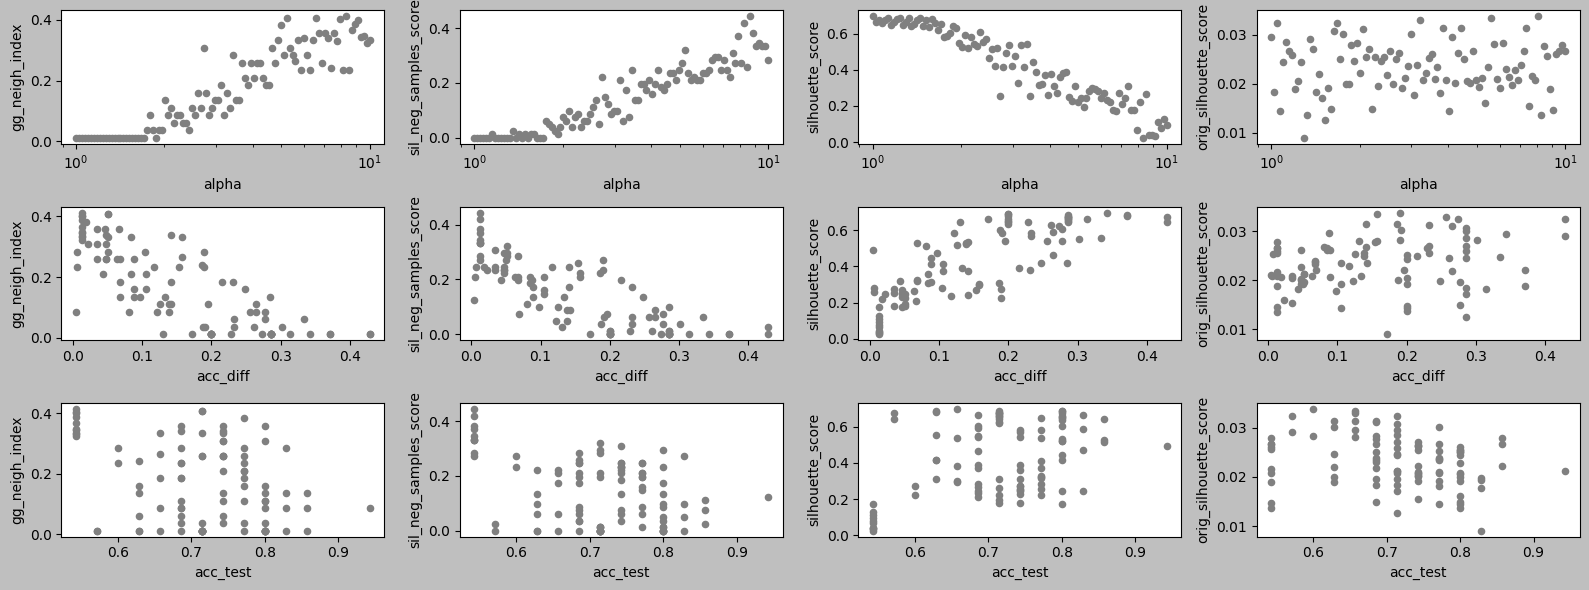

In [10]:
fig, ax = plt.subplots(3, 4, figsize=(16, 6))

# ---

df.plot.scatter(x="alpha", y="gg_neigh_index", ax=ax[0, 0])
ax[0, 0].set_xscale("log")

df.plot.scatter(x="alpha", y="sil_neg_samples_score", ax=ax[0, 1])
ax[0, 1].set_xscale("log")

df.plot.scatter(x="alpha", y="silhouette_score", ax=ax[0, 2])
ax[0, 2].set_xscale("log")

df.plot.scatter(x="alpha", y="orig_silhouette_score", ax=ax[0, 3])
ax[0, 3].set_xscale("log")

# ---

df.plot.scatter(x="acc_diff", y="gg_neigh_index", ax=ax[1, 0])

df.plot.scatter(x="acc_diff", y="sil_neg_samples_score", ax=ax[1, 1])

df.plot.scatter(x="acc_diff", y="silhouette_score", ax=ax[1, 2])

df.plot.scatter(x="acc_diff", y="orig_silhouette_score", ax=ax[1, 3])

# ---

df.plot.scatter(x="acc_test", y="gg_neigh_index", ax=ax[2, 0])

df.plot.scatter(x="acc_test", y="sil_neg_samples_score", ax=ax[2, 1])

df.plot.scatter(x="acc_test", y="silhouette_score", ax=ax[2, 2])

df.plot.scatter(x="acc_test", y="orig_silhouette_score", ax=ax[2, 3])

# ---

plt.tight_layout()
plt.show()
plt.close()

# Evaluate Distribution of the Data Projection

In [ ]:
data, target = get_australian_credit()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.values, target.values,
    stratify=target, test_size=.3
)

## Overfit

In [ ]:
alpha = 1e0

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    model = MLPClassifier(
        hidden_layer_sizes=(128, 128, 128, 128, 128, 2), activation="tanh", solver="adam",
        alpha=alpha, beta_1=0.9, beta_2=0.999,
        max_iter=1024,
        verbose=False, shuffle=False,
        early_stopping=False, validation_fraction=0.1,
        n_iter_no_change=512, tol=1e-6,
        epsilon=1e-8, learning_rate="constant",
    )

    model.fit(X_train, y_train)

    def feed_forward(a, b):
        a = np.hstack([np.ones((a.shape[0], 1)), a])
        return np.tanh(a @ b)

    coefs = [np.vstack([a.reshape(1, -1), b]) for a, b in zip(model.intercepts_[:-1], model.coefs_[:-1])]
    projection = reduce(feed_forward, [X_train] + coefs)

In [ ]:
print(classification_report(y_true=y_train, y_pred=model.predict(X_train)))

In [ ]:
print(classification_report(y_true=y_test, y_pred=model.predict(X_test)))

In [ ]:
for x in np.linspace(projection[0].min(), projection[0].max(), 100):
    for y in np.linspace(projection[1].min(), projection[1].max(), 100):
        break

In [ ]:
sel_c0 = np.where(y_train > 0)
sel_c1 = np.where(y_train < 0)

_, ax = plt.subplots(1, 2, figsize=(12, 2), sharex="all", sharey="all")

ax[0].scatter(projection[sel_c0, 0], projection[sel_c0, 1], color="red", alpha=.3)
ax[1].scatter(projection[sel_c1, 0], projection[sel_c1, 1], color="blue", alpha=.3)

plt.tight_layout()
plt.show()
plt.close()

## Right Fit

In [ ]:
alpha = 1e1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    model = MLPClassifier(
        hidden_layer_sizes=(128, 128, 128, 128, 128, 2), activation="tanh", solver="adam",
        alpha=alpha, beta_1=0.9, beta_2=0.999,
        max_iter=1024,
        verbose=False, shuffle=False,
        early_stopping=False, validation_fraction=0.1,
        n_iter_no_change=512, tol=1e-6,
        epsilon=1e-8, learning_rate="constant",
    )

    model.fit(X_train, y_train)

    def feed_forward(a, b):
        a = np.hstack([np.ones((a.shape[0], 1)), a])
        return np.tanh(a @ b)

    coefs = [np.vstack([a.reshape(1, -1), b]) for a, b in zip(model.intercepts_[:-1], model.coefs_[:-1])]
    projection = reduce(feed_forward, [X_train] + coefs)

In [ ]:
print(classification_report(y_true=y_train, y_pred=model.predict(X_train)))

In [ ]:
print(classification_report(y_true=y_test, y_pred=model.predict(X_test)))

In [ ]:
sel_c0 = np.where(y_train > 0)
sel_c1 = np.where(y_train < 0)

_, ax = plt.subplots(1, 2, figsize=(12, 2), sharex="all", sharey="all")

ax[0].scatter(projection[sel_c0, 0], projection[sel_c0, 1], color="red", alpha=.3)
ax[1].scatter(projection[sel_c1, 0], projection[sel_c1, 1], color="blue", alpha=.3)

plt.tight_layout()
plt.show()
plt.close()

---